### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.14.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2632936710386856330
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 5985950899494849018
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


In [3]:
# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from random import seed
from random import randint
seed(1)

### Data inspection

In [4]:
# Load the data from the file
file_path = 'cleaned_data.npz'
loaded_data = np.load(file_path, allow_pickle=True)

# Put data into proper arrays
data = loaded_data['data']
labels = loaded_data['labels']

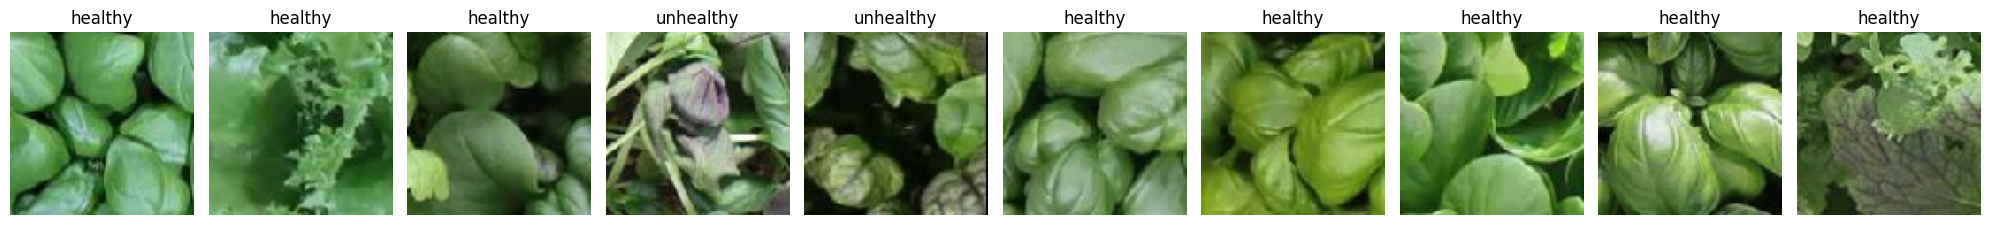

In [11]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
for i in range(num_img):
    value = randint(0, len(data))
    ax = axes[i%num_img]
    ax.imshow(data[value].astype(np.uint8), cmap = 'gray')
    label = labels[value]
    # plt.imshow((data[i]).astype(np.uint8))  # Display clipped item images
    ax.set_title(f'{labels[value]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Prepare data

In [16]:
healthy = []
unhealthy = []

# Iterate through the images and calculate their perceptual hashes
for i, image in enumerate(data):
    if (labels[i] == 'unhealthy'):
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))


3060
1790


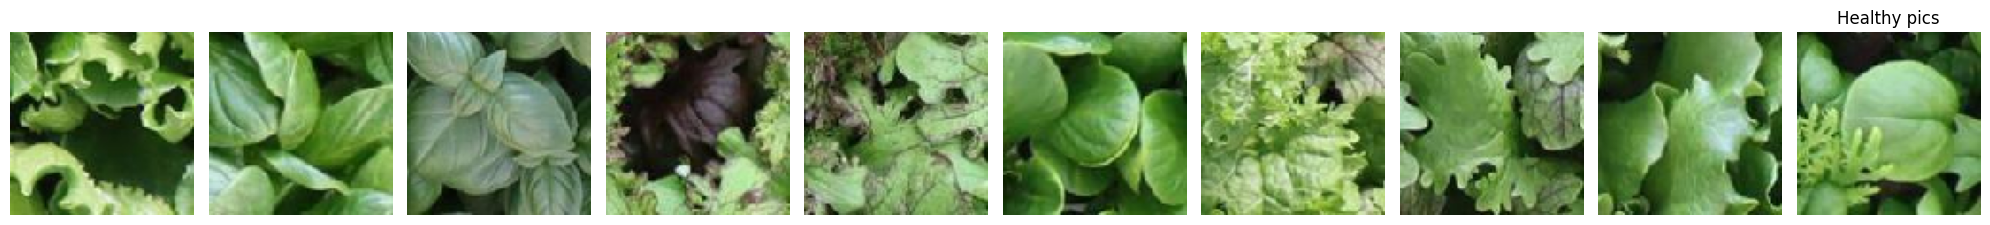

In [22]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
plt.title("Healthy pics") 
for i in range(num_img):
    value = randint(0, len(healthy))
    ax = axes[i%num_img]
    ax.imshow(healthy[value].astype(np.uint8), cmap = 'gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

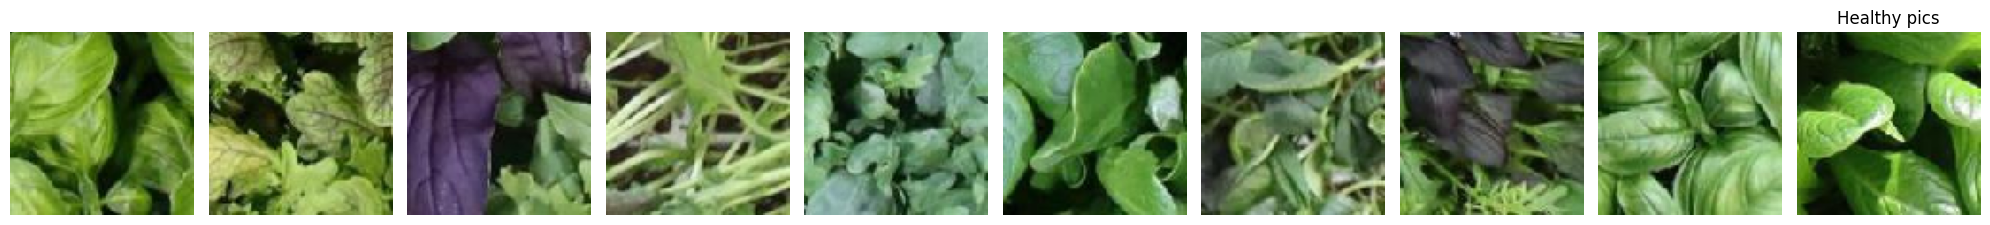

In [30]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))
plt.title("Healthy pics") 
for i in range(num_img):
    value = randint(0, len(unhealthy))
    ax = axes[i%num_img]
    ax.imshow(unhealthy[value].astype(np.uint8), cmap = 'gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
y = tfk.utils.to_categorical([0,1],2)

batch_size = 32
img_height = 96
img_width = 96

X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=seed, test_size=.25, stratify=np.argmax(y,axis=1))

InvalidParameterError: The 'random_state' parameter of train_test_split must be an int in the range [0, 4294967295], an instance of 'numpy.random.mtrand.RandomState' or None. Got <bound method Random.seed of <random.Random object at 0x13e81cc10>> instead.